## Computing Centrality Measures

In [2]:
import os
import pickle
from functools import partial
import pprint as pp
import math

import pandas as pd

import pyrosm
import osmnx as ox

import networkx as nx

### Read in the osm.pbf file and create a NetworkX graph

In [3]:
# From https://pyrosm.readthedocs.io/en/latest/basics.html?highlight=osmnx#export-to-networkx-osmnx

osm = pyrosm.OSM('./data/osm/albany-county_new-york-210101.osm.pbf')

nodes, edges = osm.get_network(nodes=True, network_type='driving')

# Export the nodes and edges to NetworkX graph
G = osm.to_graph(nodes, edges, graph_type="networkx", retain_all=True, osmnx_compatible=True)

In [4]:
def highway_type_analysis(way):
    highway = way["highway"]

    if not isinstance(highway, list):
        highway = [highway]

    # NOTE: Decimal parts are used in ranking highway types, but later dropped using math.floor.
    min_roadclass = 9
    max_roadclass = -1

    highest_highway_type = None
    lowest_highway_type = None

    for hwy in highway:
        if not isinstance(hwy, str):
            continue

        hwy = hwy.strip().lower()

        is_link = hwy.endswith('link')

        cur_roadclass = None

        if (hwy.startswith("motorway")):
            cur_roadclass = 0
        elif (hwy.startswith("trunk")):
            cur_roadclass = 1
        elif (hwy.startswith("primary")):
            cur_roadclass = 2
        elif (hwy.startswith("secondary")):
            cur_roadclass = 3
        elif (hwy.startswith("tertiary")):
            cur_roadclass = 4
        elif (hwy.startswith("residential")):
            cur_roadclass = 5
        elif (hwy.startswith("living_street")):
            # Should rank lower than residential
            cur_roadclass = 5.5
        elif (hwy.startswith("unclassified")):
            cur_roadclass = 6
        elif (hwy.startswith("service")):
            service = way["service"]

            if not isinstance(service, list):
                service = [service]

            for svc in service:
                if not isinstance(svc, str):
                    min_roadclass = 7
                elif (
                    svc.startswith('parking')
                    or svc.startswith('driveway')
                    or svc.startswith('drive-through')
                ): cur_roadclass = 8
                else:
                    cur_roadclass = 7

        if not cur_roadclass == None:
            # motorway should be considered higher highway type than motorway-link
            if is_link:
                cur_roadclass += 0.25

            if cur_roadclass < min_roadclass:
                min_roadclass = cur_roadclass
                highest_highway_type = hwy

            if cur_roadclass > max_roadclass:
                max_roadclass = cur_roadclass
                lowest_highway_type = hwy

    if (highest_highway_type == None):
        return None

    min_roadclass = math.floor(min_roadclass)
    max_roadclass = math.floor(max_roadclass)

    return {
        "min_roadclass": min_roadclass,
        "max_roadclass": max_roadclass,
        "highest_highway_type": highest_highway_type,
        "lowest_highway_type": lowest_highway_type
    }


In [5]:
for e in list(G.edges(data=True)):
    hwy_type_info = highway_type_analysis(e[2])

    if hwy_type_info is None:
        e[2]['roadclass'] = None
        continue

    if hwy_type_info['min_roadclass'] != hwy_type_info['max_roadclass']:
        raise Exception('Invariant Broken. Should not have multiple roadclasses prior to OSMnx simplification')

    e[2]['roadclass'] = hwy_type_info['min_roadclass']

In [25]:
# https://groups.google.com/g/networkx-discuss/c/mrwIDdlcA3M

# SG = nx.Graph(
#     [(u,v,d) for u,v,d in G.edges(data=True) if d['roadclass'] != None and d['roadclass'] <= 4]
# )

# Results in the following when trying to simplify using OSMnx
# ---------------------------------------------------------------------------
# KeyError                                  Traceback (most recent call last)
# Cell In[28], line 2
#       1 # Our road network graph can be represented as two GeoDataFrames
# ----> 2 ox_g = ox.simplify_graph(SG)
#       4 # WARNING: Reindexing and exporting to GPKG throws the following error:
#       5 #            ValueError: cannot insert osmid, already exists
#       6 #
#       7 # The following workaround is suggested by the library's author:
#       8 #   https://github.com/gboeing/osmnx/issues/638#issuecomment-756948363
#       9 for node, data in ox_g.nodes(data=True):
# 
# File ~/AVAIL/avail-transportation-resiliency-metrics/.direnv/python-3.10.12/lib/python3.10/site-packages/osmnx/simplification.py:372, in simplify_graph(G, strict, edge_attrs_differ, endpoint_attrs, remove_rings, track_merged)
#     368         path_attributes[attr] = list(set(path_attributes[attr]))
#     370 # construct the new consolidated edge's geometry for this path
#     371 path_attributes["geometry"] = LineString(
# --> 372     [Point((G.nodes[node]["x"], G.nodes[node]["y"])) for node in path]
#     373 )
#     375 if track_merged:
#     376     # add the merged edges as a new attribute of the simplified edge
#     377     path_attributes["merged_edges"] = merged_edges
# 
# File ~/AVAIL/avail-transportation-resiliency-metrics/.direnv/python-3.10.12/lib/python3.10/site-packages/osmnx/simplification.py:372, in <listcomp>(.0)
#     368         path_attributes[attr] = list(set(path_attributes[attr]))
#     370 # construct the new consolidated edge's geometry for this path
# ...
#     375 if track_merged:
#     376     # add the merged edges as a new attribute of the simplified edge
#     377     path_attributes["merged_edges"] = merged_edges
# 
# KeyError: 'x'

In [12]:
SG = G.copy()
# https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.remove_edge.html
for (u,v,d) in list(SG.edges(data=True)):
    hwy_type_info = highway_type_analysis(d)

    if hwy_type_info is None:
        # FIXME: Assuming this is how the nodes work for edges
        SG.remove_edge(u, v)
        continue

    if hwy_type_info['min_roadclass'] != hwy_type_info['max_roadclass']:
        raise Exception('Invariant Broken. Should not have multiple roadclasses prior to OSMnx simplification')

    roadclass = hwy_type_info['min_roadclass']

    if roadclass <= 4:
        d['roadclass'] = roadclass
    else:
        SG.remove_edge(u, v)

In [26]:
# https://groups.google.com/g/networkx-discuss/c/XmP5wZhrDMI/m/tCPul0GI_LwJ
# solitary=[ n for n in SG.node.items() if d==0 ]
# SG.delete_nodes_from(solitary)


for n in [n for n in SG.nodes()]:
    if SG.degree(n) == 0:
        SG.remove_node(n)

In [27]:
def flatten(k, v):
    v = v[k] if isinstance(v[k], list) else [v[k]]
    v = [x for x in v if isinstance(x, str)]

    return v[0] if v else None

### Use OSMnx to simplify the network

In [30]:
# Our road network graph can be represented as two GeoDataFrames
ox_g = ox.simplify_graph(SG)

# WARNING: Reindexing and exporting to GPKG throws the following error:
#            ValueError: cannot insert osmid, already exists
#
# The following workaround is suggested by the library's author:
#   https://github.com/gboeing/osmnx/issues/638#issuecomment-756948363
for node, data in ox_g.nodes(data=True):
    if 'osmid' in data:
        data['osmid_original'] = data.pop('osmid')

# NOTE: add_edge_speeds crashes without the following work around
for e in list(ox_g.edges(data=True)):
    if not (isinstance(e[2]['maxspeed'], str) or e[2]['maxspeed'] == None):
        e[2]['maxspeed'] = flatten('maxspeed', e[2])

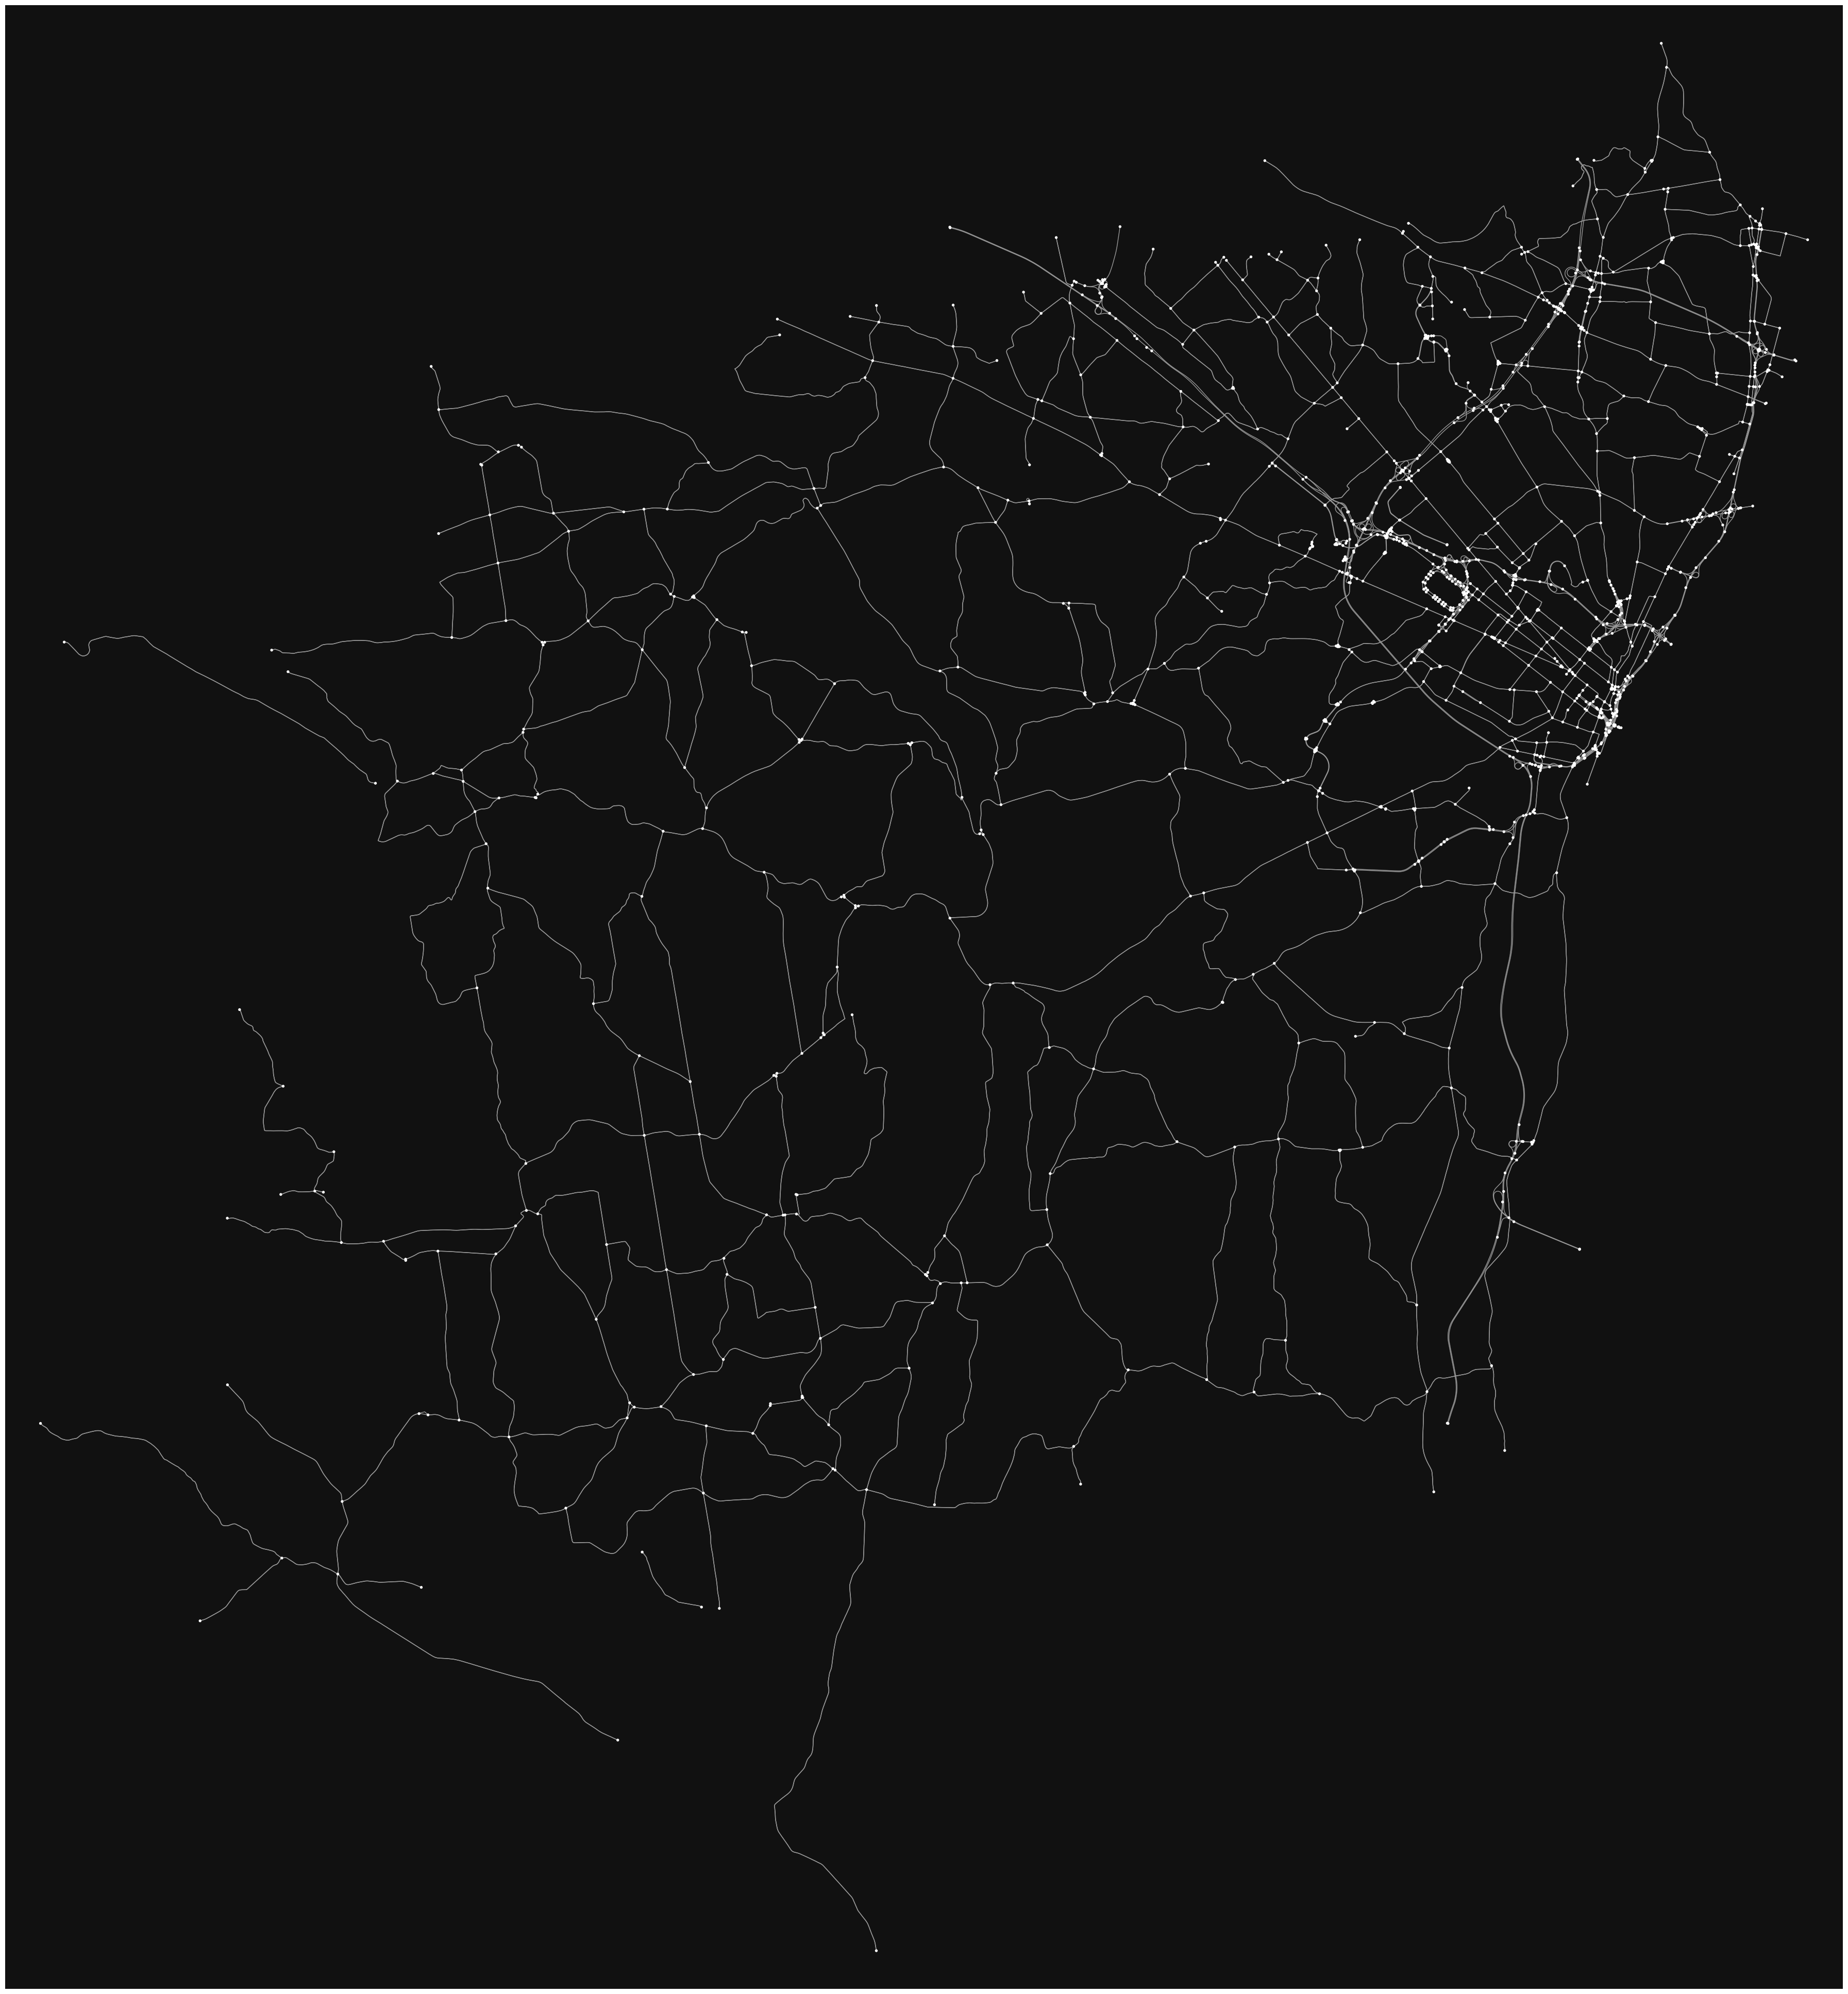

In [31]:
fig, ax = ox.plot_graph(ox_g, figsize=(50, 50))


In [32]:
# https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.routing.add_edge_speeds
ox.add_edge_speeds(ox_g)

# https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.routing.add_edge_travel_times
ox.add_edge_travel_times(ox_g)

In [33]:
node_centrality_file = 'node_betweenness_centrality.albany_major_roadways_210101.pkl'

node_betweenness_centrality = None
try:
    with open(node_centrality_file, 'rb') as file:
        node_betweenness_centrality = pickle.load(file)
except FileNotFoundError:
    print('Must compute node betweenness centrality...')
    # Note: took 5h30m to run for Albany County
    node_betweenness_centrality = nx.betweenness_centrality(ox_g, weight='travel_time')
    with open(node_centrality_file, 'wb') as f:
        pickle.dump(node_betweenness_centrality, f)

Must compute node betweenness centrality...


In [34]:
edge_centrality_file = 'edge_betweenness_centrality.albany_major_roadways_210101.pkl'

try:
    with open(edge_centrality_file, 'rb') as file:
        edge_betweenness_centrality = pickle.load(file)
except FileNotFoundError:
    print('Must compute edge betweenness centrality...')
    # Note: took 5h30m to run for Albany County
    edge_betweenness_centrality = nx.edge_betweenness_centrality(ox_g, weight='travel_time')
    with open(edge_centrality_file, 'wb') as f:
        pickle.dump(edge_betweenness_centrality, f)

Must compute edge betweenness centrality...


In [35]:
g = ox_g.copy()

for node, data in list(g.nodes(data=True)):
    data['centrality'] = node_betweenness_centrality[node]

for (u,v,d) in list(g.edges(data=True)):
    d['centrality'] = edge_betweenness_centrality[(u,v,0)]

In [36]:
output_file_name = 'albany_major_roadways_210101.with_betweenness_centrality.gpkg'

try:
    os.remove(output_file_name)
except OSError:
    pass

gdf_nodes, gdf_relationships = ox.graph_to_gdfs(g)

gdf_nodes.to_file(output_file_name, layer='intersections', driver='GPKG')
gdf_relationships.to_file(output_file_name, layer='roadways', driver='GPKG')